In [9]:
import numpy as np
import math
import pandas as pd
from pandas import DataFrame,Series
import os
import matplotlib.pyplot as plt
import datetime

os.chdir("../data/")

the root mean square error for model 1 is: 0.004234220070766974
the  root mean square error  for model 2 is: 0.003759331359156947
the  root mean square error  for model 3 is: 0.0036533930065625092


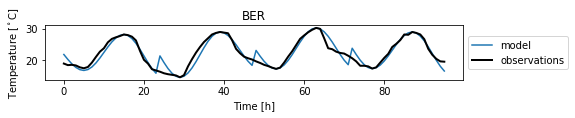

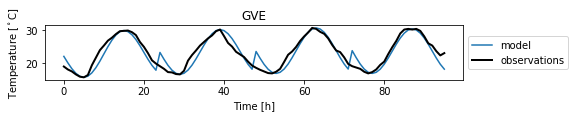

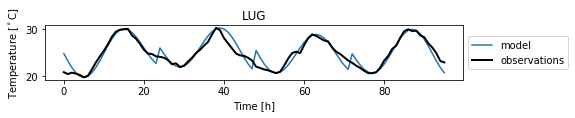

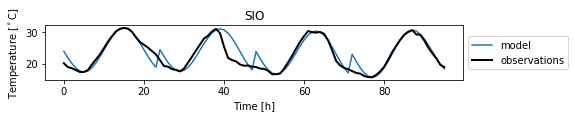

In [91]:
hourly_temp=pd.read_csv('ch_hourly_temp_s2018.txt', sep=";")

stations = {'Bern','Geneva','Lugano','Sion'}
minimums = {}
maximums = {}
days=93 # number of days

a=0 #counter to know when we change stations as the data is all after another
for station in ch.stn.unique():
    if station!='stn':
        t = np.arange(0,24) # 24 hours

        T = hourly_temp[hourly_temp['stn']==station]['tre200h0']
        T = T.astype(float)

        max_T = np.zeros(days)
        min_T = np.zeros(days)
        h_max = np.zeros(days)
        h_min = np.zeros(days)

        t0 = 0
        for d in range(days):

            Tj = T[t0:t0+24] #get hours one day at a time
            max_T[d] = np.max(Tj) # maximum temperature of each day
            min_T[d] = np.min(Tj) #minimum temperature of each day

            h_max[d] = Series.idxmax(Tj) #hour at which the temperature is maximum
            h_max[d] = h_max[d]-24*d-a 
            h_min[d] = Series.idxmin(Tj)
            h_min[d] = h_min[d]-24*d-a


            t0=t0+24 #counter of days

            minimums[station]=min_T
            maximums[station]=max_T

    a=a+2233
    
#################################################################################################    

cos=math.cos
pi=math.pi
SE1=0
SE2=0
SE3=0

h_min=5. # set minimum temperature to happen at 5h
h_max=15. # set maximum temperature to hapen at 15h
rise= h_min

t0=0



#try out different models for each stations:

for station in hourly_temp.stn.unique():
    if station!='stn':

        max_T=maximums[station] 
        min_T=minimums[station] 



        #########################################################################################################################
        #model 1

        Tave=np.zeros(93)
        amp=np.zeros(93)
        Tave=(min_T+max_T)/2
        amp=(max_T-min_T)/2

        d=0

        for t in range (0,2232):

            h=hourly_temp.iloc[t]['time']
            h=str(h)
            h=int(h[-2 :])

            if 0 <= h < rise or h_max < h <= 24:

                if 0 <= h < rise: 

                    hp = h+10

                if h  > h_max:

                    hp = h+14

                T_est = Tave[d] + amp[d] * ( cos ( pi * hp / (10.+rise) ) )


            if rise <= h<= 14:

                T_est = Tave[d] - amp[d] * ( cos ( pi* (h-rise) / (14.-rise) ) ) 


            hourly_temp.at[t,'model 1'] = T_est

            if h == 23: 
                d = d+1

        ###################################################################################################
        #model 2            

        d=0


        for t in range(0,2232): 

            h=str(hourly_temp.iloc[t]['time'])
            h=int(h[-2 :])

            if h < h_min:

                f1  =  ( cos ( pi * ( h_min-h ) / ( 24+h_min-h_max ) ) +1 ) / 2

            if h_min <= h <= h_max: 

                f1  =  ( cos ( pi * ( h-h_min ) / ( h_max-h_min) ) +1 ) / 2

            if h_max<h:

                f1  =  ( cos ( pi * ( 24+h_min-h ) / ( 24+h_min-h_max ) ) + 1 ) / 2

            f2 = 1-f1


            T_est = f1*min_T[d]+f2*max_T[d] 


            hourly_temp.at[t,'model 2']= T_est


            if h == 23: 
                d=d+1 
        ####################################################################################################################
        #model 3


        d=1

        for t in range (24,2208):

            h = str(hourly_temp.iloc[t]['time'])
            h = int(h[-2 :])


            if  h_min <= h < h_max:
                T_est=((max_T [d] + min_T[d]) / 2 - (max_T[d] - min_T[d]) / 2 * cos ( pi *(h-h_min)/(h_max - h_min)))

            if   0 <= h < h_min:
                T_est = ((max_T [d-1] + min_T[d]) /2)-((min_T[d] - max_T[d-1]) /2 * cos( pi*( h-h_max)/(h_min-h_max)))

            if  h_max <= h <= 23:
                T_est = (min_T[d+1] +  max_T[d]) / 2 - ( min_T[d+1] - max_T[d] )/2 *cos(pi*(h-h_max) / (h_min-h_max))

            if  h == 23: 
                d = d+1 

            hourly_temp.at[t,'model 3']= T_est




        fig, ax = plt.subplots(figsize=(7.5, 1))

        start_day=60
        d=4
        time=np.arange(0,d*24)

        s=start_day*24
        e=(start_day+d)*24

        #ax.plot(time,model['T_est'][s:e],label='model 1')
        #ax.plot(time,model2['T_est'][s:e],label='model 2')
        ax.plot(time,hourly_temp['model 3'][s:e],label='model')

        s=s+t0
        e=e+t0

        ax.plot(time,pd.to_numeric(hourly_temp['tre200h0'][s:e]),color='k',label='observations',linewidth=2)
        ax.legend(loc='center left',bbox_to_anchor=(1, 0.5))
        ax.set_xlabel('Time [h]')
        ax.set_ylabel('Temperature [$^\circ$C]')
        ax.set_title(station)
        plt.savefig(''.join(['../figures/',station,'_','hourly_temperature.pdf']),bbox_inches='tight')   


        e1 = np.zeros(2232)
        e2 = np.zeros(2232)
        e3 = np.zeros(2232)



        for t in range (24,2208):

            h = model.iloc[t]['time']
            h = str(h)
            h = int(h[-2 :])

            if 8 < h < 18:
                i=i+1
                e1[t] = float(hourly_temp.iloc[t]['model 1'])-float(hourly_temp.iloc[t]['tre200h0'])
                e2[t] = float(hourly_temp.iloc[t]['model 2'])-float(hourly_temp.iloc[t]['tre200h0'])
                e3[t] = float(hourly_temp.iloc[t]['model 3'])-float(hourly_temp.iloc[t]['tre200h0'])


        E1 = np.linalg.norm(e1,2)/i
        E2 = np.linalg.norm(e2,2)/i
        E3 = np.linalg.norm(e3,2)/i


        SE1=SE1+E1
        SE2=SE2+E2
        SE3=SE3+E3



    
        t0=t0+2233
##########################################################
#average error of each model for the four stations

SE1=SE1/4
SE2=SE2/4    
SE3=SE3/4    

print('the root mean square error for model 1 is:',E1)
print('the  root mean square error  for model 2 is:',E2)
print('the  root mean square error  for model 3 is:',E3)

#########################################################

